In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
import pandas as pd
import shutil
torch.set_num_threads(4)

In [3]:
# parameters cell (required to pass arguments to the notebook)
HPO_ITER = 5  # number of HPO iterations for final modeling run

# GNN Models with Custom Gene Co-expression Networks

In [4]:
import subprocess

if not os.path.exists("dataset1"):
    # Check if wget is available
    if shutil.which("wget"):
        !wget -O dataset1.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/dataset1.tgz" && tar -xzvf dataset1.tgz
    else:
        # Use curl as fallback
        !curl -L -o dataset1.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/dataset1.tgz" && tar -xzvf dataset1.tgz

Let's check the data structure:

In [5]:
# Check train data dimensions
!wc -l ./dataset1/train/*

     921 ./dataset1/train/clin.csv
     158 ./dataset1/train/cnv.csv
    3423 ./dataset1/train/gex.csv
    4502 total


In [6]:
# Check test data dimensions
!wc -l ./dataset1/test/*

     931 ./dataset1/test/clin.csv
     158 ./dataset1/test/cnv.csv
    3423 ./dataset1/test/gex.csv
    4512 total


## Part 1: Import Data

We import the multiomics data using Flexynesis DataImporter. For GNN models, we'll use gene expression (gex) and copy number (cnv) data.

In [7]:
data_importer = flexynesis.data.DataImporter(
    path='./dataset1/', 
    data_types=['gex', 'cnv'], 
    concatenate=False,  # Intermediate fusion
    top_percentile=20,  # Keep top 20% features by Laplacian score
    min_features=100,
    variance_threshold=0.5
)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./dataset1/train/gex.csv...
[INFO] Importing ./dataset1/train/cnv.csv...
[INFO] Importing ./dataset1/train/clin.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./dataset1/test/gex.csv...
[INFO] Importing ./dataset1/test/cnv.csv...
[INFO] Importing ./dataset1/test/clin.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 1711 features.

[INFO] working on layer:  cnv
[INFO] Number of NA values:  0
[INFO] DataFrame cnv - Removed 78 features.
[INFO] DataFrame gex - Removed 

Filtering redundant features: 100%|██████████| 342/342 [00:00<00:00, 9455.04it/s]


[INFO] Implementing feature selection using laplacian score for layer: cnv with  79 features  and  920  samples 
[INFO] No feature selection applied. Returning original matrix. Demanded # of features is  larger than existing number of features

[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  gex
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 1711 features.

[INFO] working on layer:  cnv
[INFO] Number of NA values:  0
[INFO] DataFrame cnv - Removed 78 features.
[INFO] DataFrame gex - Removed 0 samples (0.00%).
[INFO] DataFrame cnv - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: cnv': 

In [8]:
# Check the imported data structure
print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Data types:", list(train_dataset.dat.keys()))

Training samples: 920
Test samples: 930
Data types: ['cnv', 'gex']


## Part 2: GNN with Default STRING Network

First, let's train a GNN model using the default STRING protein-protein interaction network. Flexynesis will automatically download and use STRING data if no custom network is provided.

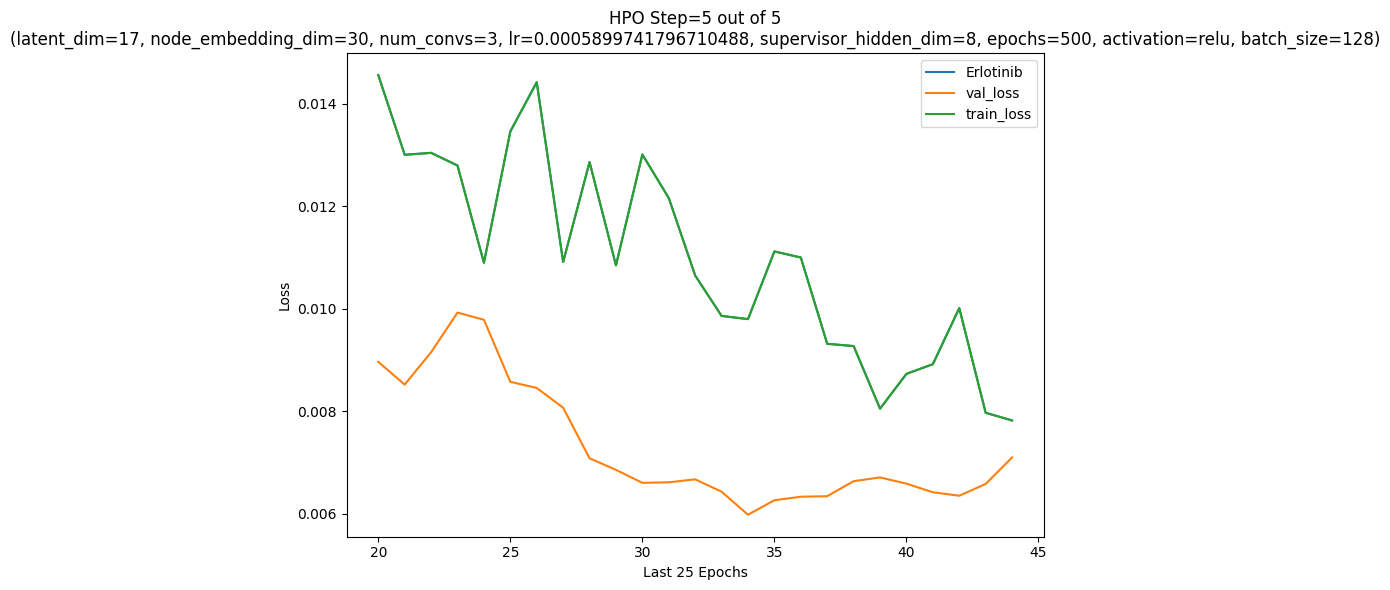

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Erlotinib         │   0.007097391877323389    │
│         val_loss          │   0.007097391877323389    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [02:39<00:00, 31.93s/it, Iteration=5, Best Loss=0.00353]

[INFO] current best val loss: 0.0035296203568577766; best params: {'latent_dim': 105, 'node_embedding_dim': 9, 'num_convs': 3, 'lr': 0.001562069367563987, 'supervisor_hidden_dim': 19, 'epochs': 500, 'activation': 'relu', 'batch_size': 64} since 4 hpo iterations


In [9]:
# Train GNN with STRING network
from flexynesis.data import STRING, MultiOmicDatasetNW

# Use STRING DB for protein-protein interactions 
print("[INFO] Loading STRING DB network...")
string_obj = STRING(
    organism=9606,  # human
    node_name='gene_name'
)
graph_df_string = string_obj.graph_df
print(f"[INFO] Loaded {len(graph_df_string)} interactions from STRING DB")

# Wrap datasets with network
train_dataset_string = MultiOmicDatasetNW(train_dataset, graph_df_string)
test_dataset_string = MultiOmicDatasetNW(test_dataset, graph_df_string)

print("\nTrain dataset network statistics:")
train_dataset_string.print_stats()

# Create tuner with network-wrapped dataset
tuner_string = flexynesis.main.HyperparameterTuning(
    dataset=train_dataset_string,
    model_class=flexynesis.models.GNN,
    target_variables=['Erlotinib'],
    config_name='GNN',
    gnn_conv_type='GCN',
    n_iter=HPO_ITER,
    early_stop_patience=10,
    plot_losses=True  
)
model_string, best_params_string = tuner_string.perform_tuning()

In [31]:
# Check model performance
print("\nSTRING Network Model Performance:")
print(f"Best parameters: {best_params_string}")
print(model_string)


STRING Network Model Performance:
Best parameters: {'latent_dim': 105, 'node_embedding_dim': 9, 'num_convs': 3, 'lr': 0.001562069367563987, 'supervisor_hidden_dim': 19, 'epochs': 22, 'activation': 'relu', 'batch_size': 64}
GNN(
  (log_vars): ParameterDict(  (Erlotinib): Parameter containing: [torch.mps.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): flexGCN(
      (act): ReLU()
      (convs): ModuleList(
        (0): GCNConv(2, 9)
        (1-2): 2 x GCNConv(9, 9)
      )
      (bns): ModuleList(
        (0-2): 3 x BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (fc): Linear(in_features=2034, out_features=105, bias=True)
    )
  )
  (MLPs): ModuleDict(
    (Erlotinib): MLP(
      (layer_1): Linear(in_features=105, out_features=19, bias=True)
      (layer_out): Linear(in_features=19, out_features=1, bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (

## Part 3: Generate Custom Co-expression Networks

Now let's generate custom gene co-expression networks from our gene expression data. Co-expression networks can capture disease-specific or context-specific gene relationships that may not be present in general protein-protein interaction databases.

### Method 1: Pearson Correlation (Linear Relationships)

Pearson correlation captures linear relationships between genes. It's faster to compute and works well when relationships are approximately linear.

In [11]:
# Read gene expression data for network generation
gex_train = pd.read_csv('./dataset1/train/gex.csv', index_col=0)
print(f"Gene expression matrix: {gex_train.shape[0]} genes × {gex_train.shape[1]} samples")

# Generate Pearson co-expression network using 
from flexynesis.generate_coexpression_network import generate_coexpression_network

generate_coexpression_network(
    input_file='./dataset1/train/gex.csv',
    output_file='./pearson_network.csv',
    method='pearson',
    min_correlation=0.4,
    top_k=10
)

Gene expression matrix: 3422 genes × 920 samples
Co-expression Network Generator

[1/3] Loading expression data from: ./dataset1/train/gex.csv
  Expression matrix: 3422 genes × 920 samples

[2/3] Building network...
Using device: mps
Calculating pearson correlations for 3422 genes...
Standardizing data...
Computing correlations and building network (min |r| = 0.4, top 10 per gene)...


Processing genes: 100%|██████████| 3422/3422 [00:10<00:00, 328.99it/s]


Removing duplicate edges...
  Removed 2986 duplicate edges

[3/3] Saving network to: ./pearson_network.csv

Network Generation Complete!

Network Statistics:
  Total edges: 17,771
  Unique genes (GeneA): 2,538
  Unique genes (GeneB): 1,731
  All unique genes: 2,626
  Score range: [0.4000, 0.8050]
  Mean score: 0.5252
  Median score: 0.5090

Sample edges (first 5):
GeneA  GeneB    Score
 A1CF TM4SF5 0.788863
 A1CF    DDC 0.765934
 A1CF  FABP1 0.674972
 A1CF ANXA13 0.633710
 A1CF SPINK1 0.629511

Usage with Flexynesis:

flexynesis --data_path <data_path> \
  --model_class GNN \
  --gnn_conv_type GCN \
  --target_variables <target> \
  --data_types gex,cnv \
  --user_graph ./pearson_network.csv



### Method 2: Spearman Correlation (Rank-based Relationships)

Spearman correlation is more robust to outliers and can capture monotonic (not necessarily linear) relationships. It's often preferred for biological data.

In [12]:
generate_coexpression_network(
    input_file='./dataset1/train/gex.csv',
    output_file='./spearman_network.csv',
    method='spearman',
    min_correlation=0.5,
    top_k=10
)

Co-expression Network Generator

[1/3] Loading expression data from: ./dataset1/train/gex.csv
  Expression matrix: 3422 genes × 920 samples

[2/3] Building network...
Using device: mps
Calculating spearman correlations for 3422 genes...
Computing ranks...


Converting to ranks: 100%|██████████| 3422/3422 [00:00<00:00, 289653.46it/s]


Standardizing data...
Computing correlations and building network (min |r| = 0.5, top 10 per gene)...


Processing genes: 100%|██████████| 3422/3422 [00:05<00:00, 655.14it/s]


Removing duplicate edges...
  Removed 1475 duplicate edges

[3/3] Saving network to: ./spearman_network.csv

Network Generation Complete!

Network Statistics:
  Total edges: 6,617
  Unique genes (GeneA): 1,147
  Unique genes (GeneB): 733
  All unique genes: 1,240
  Score range: [0.5000, 0.7991]
  Mean score: 0.5827
  Median score: 0.5721

Sample edges (first 5):
GeneA   GeneB    Score
ABCC3    NQO1 0.629282
ABCC3  S100A6 0.624751
ABCC3 ALDH3B1 0.612975
ABCC3   EPHA2 0.603549
ABCC3   ITGA3 0.598484

Usage with Flexynesis:

flexynesis --data_path <data_path> \
  --model_class GNN \
  --gnn_conv_type GCN \
  --target_variables <target> \
  --data_types gex,cnv \
  --user_graph ./spearman_network.csv



Let's examine the generated networks:

In [13]:
# Load and inspect the networks
pearson_net = pd.read_csv('./pearson_network.csv')
spearman_net = pd.read_csv('./spearman_network.csv')

print("Pearson Network Statistics:")
print(f"  Total edges: {len(pearson_net):,}")
print(f"  Unique genes: {len(set(pearson_net['GeneA']) | set(pearson_net['GeneB'])):,}")
print(f"  Score range: [{pearson_net['Score'].min():.3f}, {pearson_net['Score'].max():.3f}]")
print(f"  Mean score: {pearson_net['Score'].mean():.3f}")

print("\nSpearman Network Statistics:")
print(f"  Total edges: {len(spearman_net):,}")
print(f"  Unique genes: {len(set(spearman_net['GeneA']) | set(spearman_net['GeneB'])):,}")
print(f"  Score range: [{spearman_net['Score'].min():.3f}, {spearman_net['Score'].max():.3f}]")
print(f"  Mean score: {spearman_net['Score'].mean():.3f}")

Pearson Network Statistics:
  Total edges: 17,771
  Unique genes: 2,626
  Score range: [0.400, 0.805]
  Mean score: 0.525

Spearman Network Statistics:
  Total edges: 6,617
  Unique genes: 1,240
  Score range: [0.500, 0.799]
  Mean score: 0.583


## Part 4: Train GNN with Custom Networks

Now let's train GNN models using our custom co-expression networks and compare their performance with the STRING network baseline.

### GNN with Pearson Co-expression Network

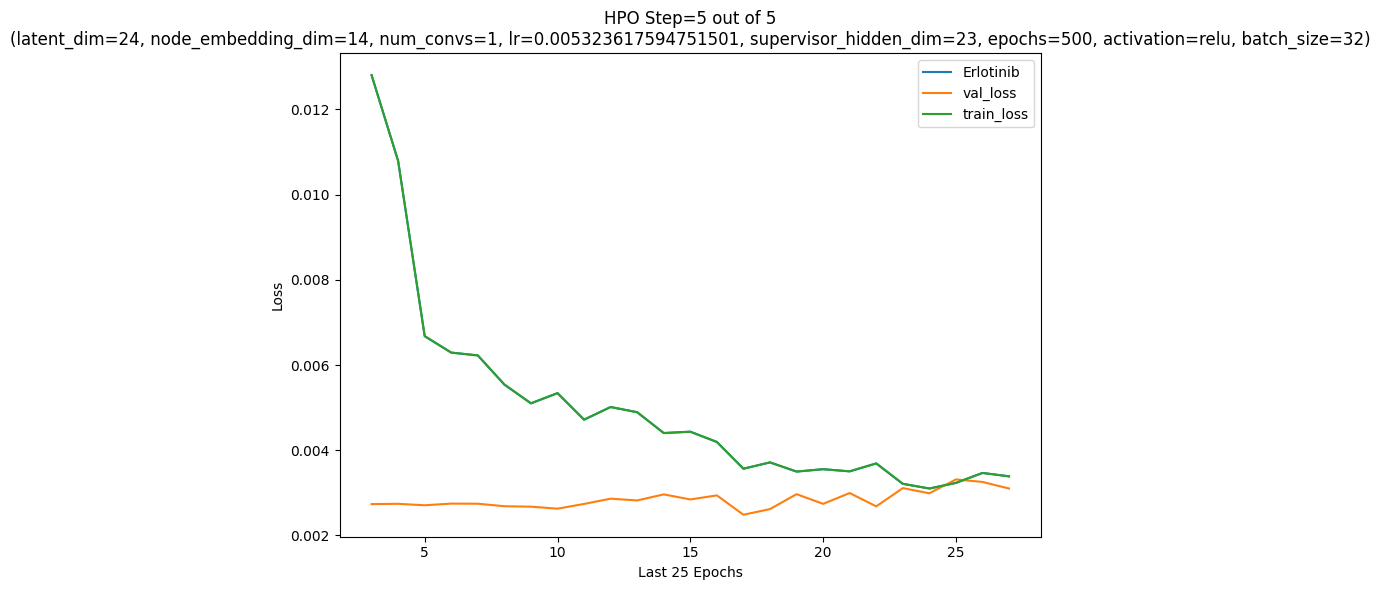

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Erlotinib         │    0.00310201826505363    │
│         val_loss          │    0.00310201826505363    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [02:40<00:00, 32.13s/it, Iteration=5, Best Loss=0.0031]

[INFO] current best val loss: 0.00310201826505363; best params: {'latent_dim': 24, 'node_embedding_dim': 14, 'num_convs': 1, 'lr': 0.005323617594751501, 'supervisor_hidden_dim': 23, 'epochs': 500, 'activation': 'relu', 'batch_size': 32} since 0 hpo iterations


In [14]:
# Train GNN with Pearson network
from flexynesis.data import read_user_graph

# Load the custom Pearson network
print("[INFO] Loading Pearson co-expression network...")
graph_df_pearson = read_user_graph('./pearson_network.csv')
print(f"[INFO] Loaded {len(graph_df_pearson)} interactions from Pearson network")

# Wrap datasets with Pearson network
train_dataset_pearson = MultiOmicDatasetNW(train_dataset, graph_df_pearson)
test_dataset_pearson = MultiOmicDatasetNW(test_dataset, graph_df_pearson)

print("\nTrain dataset network statistics:")
train_dataset_pearson.print_stats()

# Create tuner with Pearson network
tuner_pearson = flexynesis.main.HyperparameterTuning(
    dataset=train_dataset_pearson,
    model_class=flexynesis.models.GNN,
    target_variables=['Erlotinib'],
    config_name='GNN',
    gnn_conv_type='GCN',
    n_iter=HPO_ITER,
    early_stop_patience=10,
    plot_losses=True  
)
model_pearson, best_params_pearson = tuner_pearson.perform_tuning()

In [15]:
print("\nPearson Network Model Performance:")
print(f"Best parameters: {best_params_pearson}")


Pearson Network Model Performance:
Best parameters: {'latent_dim': 24, 'node_embedding_dim': 14, 'num_convs': 1, 'lr': 0.005323617594751501, 'supervisor_hidden_dim': 23, 'epochs': 27, 'activation': 'relu', 'batch_size': 32}


### GNN with Spearman Co-expression Network

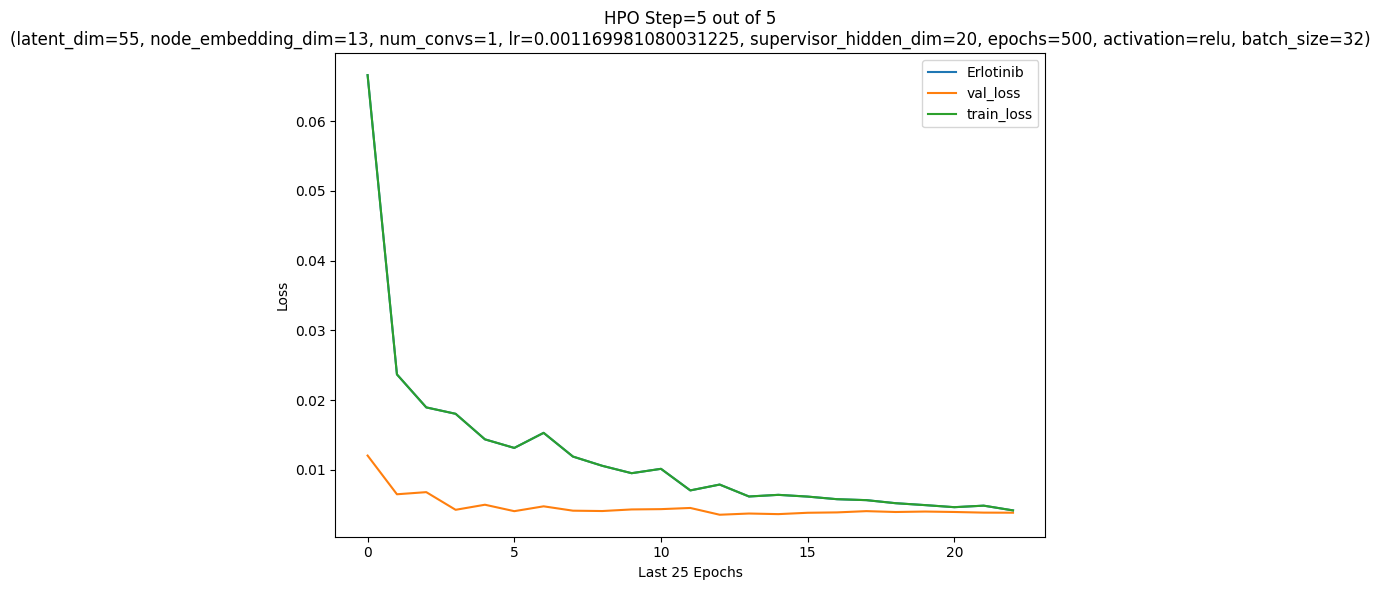

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Erlotinib         │   0.0038503101095557213   │
│         val_loss          │   0.0038503101095557213   │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [02:16<00:00, 27.39s/it, Iteration=5, Best Loss=0.00314]

[INFO] current best val loss: 0.003140417393296957; best params: {'latent_dim': 40, 'node_embedding_dim': 16, 'num_convs': 4, 'lr': 0.000445338294938445, 'supervisor_hidden_dim': 11, 'epochs': 500, 'activation': 'relu', 'batch_size': 32} since 1 hpo iterations


In [16]:
# Train GNN with Spearman network
# Load the custom Spearman network
print("[INFO] Loading Spearman co-expression network...")
graph_df_spearman = read_user_graph('./spearman_network.csv')
print(f"[INFO] Loaded {len(graph_df_spearman)} interactions from Spearman network")

# Wrap datasets with Spearman network
train_dataset_spearman = MultiOmicDatasetNW(train_dataset, graph_df_spearman)
test_dataset_spearman = MultiOmicDatasetNW(test_dataset, graph_df_spearman)

print("\nTrain dataset network statistics:")
train_dataset_spearman.print_stats()

# Create tuner with Spearman network
tuner_spearman = flexynesis.main.HyperparameterTuning(
    dataset=train_dataset_spearman,
    model_class=flexynesis.models.GNN,
    target_variables=['Erlotinib'],
    config_name='GNN',
    gnn_conv_type='GCN',
    n_iter=HPO_ITER,
    early_stop_patience=10,
    plot_losses=True  
)
model_spearman, best_params_spearman = tuner_spearman.perform_tuning()

In [17]:
print("\nSpearman Network Model Performance:")
print(f"Best parameters: {best_params_spearman}")


Spearman Network Model Performance:
Best parameters: {'latent_dim': 40, 'node_embedding_dim': 16, 'num_convs': 4, 'lr': 0.000445338294938445, 'supervisor_hidden_dim': 11, 'epochs': 40, 'activation': 'relu', 'batch_size': 32}


## Part 5: Compare Model Performance

Let's compare the performance of all three models:

We'll evaluate models on the test set and compare their performance using multiple metrics:
- **R² Score**: Proportion of variance explained (higher is better)
- **Pearson Correlation**: Strength/direction of linear relationship (-1 to +1). Absolute value closer to 1 is stronger.
- **MSE**: Mean Squared Error (lower is better)

In [ ]:
from flexynesis.utils import evaluate_regressor
import pandas as pd

# Make predictions on test datasets 
y_pred_string = model_string.predict(test_dataset_string)
y_pred_pearson = model_pearson.predict(test_dataset_pearson)
y_pred_spearman = model_spearman.predict(test_dataset_spearman)

# Get true values (excluding NaN)
y_true = test_dataset_string.ann['Erlotinib']
ind = ~torch.isnan(y_true)
y_true_valid = y_true[ind]

metrics_string = evaluate_regressor(y_true_valid, y_pred_string['Erlotinib'][ind].flatten())
metrics_pearson = evaluate_regressor(y_true_valid, y_pred_pearson['Erlotinib'][ind].flatten())
metrics_spearman = evaluate_regressor(y_true_valid, y_pred_spearman['Erlotinib'][ind].flatten())

# Create comparison dataframe
comparison = pd.DataFrame({
    'Network Type': ['STRING (PPI)', 'Pearson Co-expression', 'Spearman Co-expression'],
    'R² Score': [metrics_string['r2'], metrics_pearson['r2'], metrics_spearman['r2']],
    'Pearson Correlation': [metrics_string['pearson_corr'], metrics_pearson['pearson_corr'], metrics_spearman['pearson_corr']],
    'MSE': [metrics_string['mse'], metrics_pearson['mse'], metrics_spearman['mse']]
})

comparison

,Network Type,R² Score,Pearson Correlation,MSE
0,STRING (PPI),0.242650,0.492595,0.005444
1,Pearson Co-expression,0.152543,0.390568,0.005748
2,Spearman Co-expression,0.167659,0.409461,0.005711


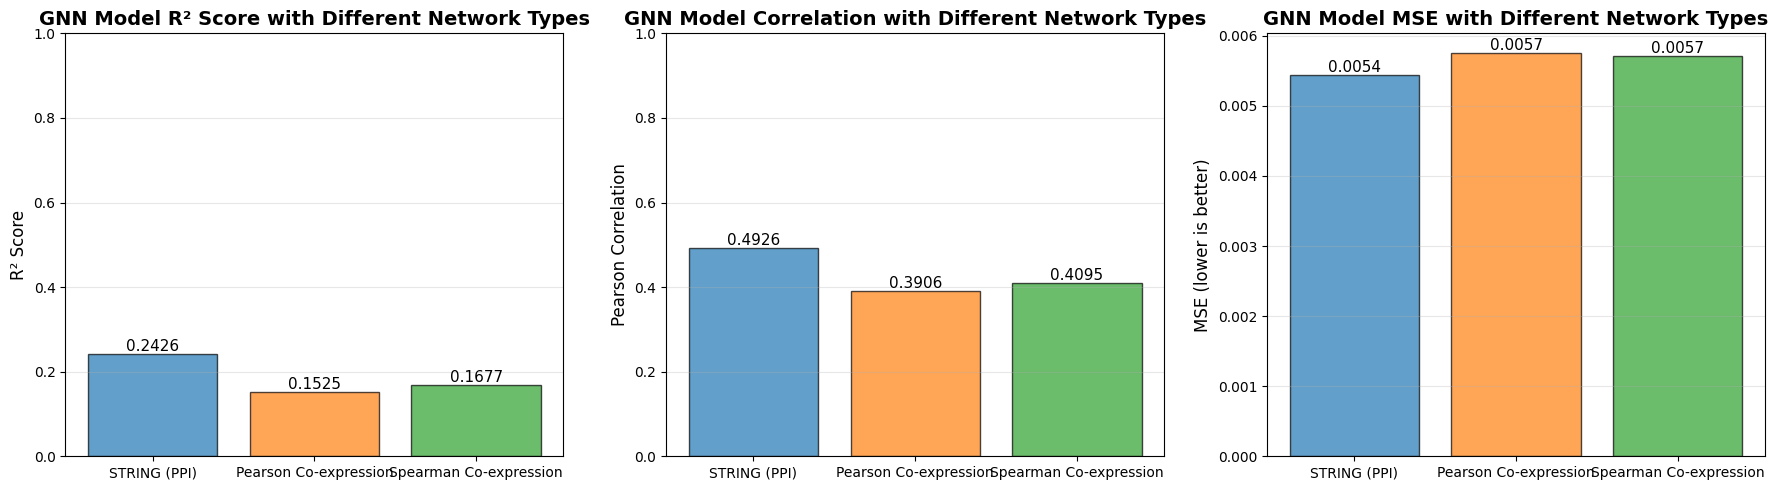

In [40]:
import matplotlib.pyplot as plt

# Plot comparison of model performances
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# R² Score comparison
bars1 = ax1.bar(comparison['Network Type'], comparison['R² Score'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('GNN Model R² Score with Different Network Types', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11)

# Pearson Correlation comparison
bars2 = ax2.bar(comparison['Network Type'], comparison['Pearson Correlation'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('Pearson Correlation', fontsize=12)
ax2.set_title('GNN Model Correlation with Different Network Types', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11)

# MSE comparison (lower is better, so invert the y-axis visually)
bars3 = ax3.bar(comparison['Network Type'], comparison['MSE'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
ax3.set_ylabel('MSE (lower is better)', fontsize=12)
ax3.set_title('GNN Model MSE with Different Network Types', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()